In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/dataassignment'

/content/drive/My Drive/dataassignment


In [3]:
import pandas as pd
file_name = 'Roman-Urdu.txt'
filee=open(file_name)
English_Content=[]
for line in filee:
  English_Content.append(line.replace('\n',''))

file_name='Urdu.txt'
filee=open(file_name)
Urdu_Content=[]
for line in filee:
  Urdu_Content.append(line.replace('\n',''))

df1 = pd.Series(English_Content)
df2 = pd.Series(Urdu_Content)
data=pd.concat([df1, df2], axis=1)
data.rename(columns = {0:'Roman',1:'Urdu'}, inplace = True)

In [4]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 2.5 MB/s eta 0:00:00


In [5]:
import warnings
warnings.filterwarnings('ignore')
import string
import re
from unicodedata import normalize
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [6]:
dataset = data.sample(frac=1, random_state=0)
dataset.iloc[1000:1010]

,Roman,Urdu
1056668,aatish bhi un ki shayarana spahyanh salahiyato...,آتش بھی ان کی شاعرانہ سپاہیانہ صلاحیتوں سے مت...
259385,hum boltay ja rahay hain aik aap hain ke jawab...,ہم بولتے جا رہے ہیں ایک آپ ہیں کہ جواب ہی نہیں...
363643,bohat hi umdah intikhab !,بہت ہی عمدہ انتخاب !
647189,bilkul nahi mein ne himmat haar di to insaaf k...,بالکل نہیں میں نے ہمت ہار دی تو انصاف کا کیا ہ...
426418,hamein ki farsi mein masters ki degree laa day !,ہمیں کوئی فارسی میں ماسٹرز کی ڈگری لا دے !
968139,aah sukh pooch sitam gaar ke tujh se bhi hamein,آہ مت پوچھ ستم گار کہ تجھ سے تھی ہمیں
328542,umeed hai ke ghazal zaroor mukammal karen ge !,امید ہے کہ غزل ضرور مکمل کریں گے !
922438,is taraf dekho sabhi is ke hi gham se mar raha...,اس طرف دیکھو سبھی اس کے ہی غم سے مر رہے ہیں
881266,Hamza kazmi jee,حمزہ کاظمی جی
592229,brigidyr aftaab Ahmed,بریگیڈئر آفتاب احمد


In [7]:
total_sentences = 1000
test_proportion = 0.1
train_test_threshold = int( (1-test_proportion) * total_sentences)

printmd(f'## {total_sentences} "parallel sentences" will be loaded (original sentence + its translation)')
printmd(f'## {train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'## {total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

## 1000 "parallel sentences" will be loaded (original sentence + its translation)

## 900 "parallel sentences" will be used to train the model

## 100 "parallel sentences" will be used to test the model

In [8]:
def clean(string):
    # Clean the string
    string = str(string).replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()
    
    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
        
    string = re.sub('\s+',' ', string)
    string = string.strip()
           
    return string


# Clean the sentences
dataset["Roman"] = dataset["Roman"].apply(lambda x: clean(x))
dataset["Urdu"] = dataset["Urdu"].apply(lambda x: clean(x))

# Select one part of the dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

# split into train/test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "Urdu", "Roman"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 1, 0

In [9]:
pd.DataFrame(dataset[1000:1010])

,0,1


In [10]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 0 , 'CPU': 4} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [11]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X
 
def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')
 
# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (Roman) Vocabulary Size: 2463

Target (Roman) Max Length: 67


Source (Urdu) Vocabulary Size: 2642

Source (Urdu) Max Length: 67


In [12]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
 
# Create model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

history = model.fit(trainX, 
          trainY, 
          epochs=200, 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=2,
                        restore_best_weights=True
                    )
            ])

Epoch 1/200
13/13 [==============================] - 18s 439ms/step - loss: 5.7637 - val_loss: 1.5551
Epoch 2/200
13/13 [==============================] - 4s 290ms/step - loss: 1.3604 - val_loss: 1.2269
Epoch 3/200
13/13 [==============================] - 3s 247ms/step - loss: 1.3089 - val_loss: 1.1642
Epoch 4/200
13/13 [==============================] - 3s 193ms/step - loss: 1.1519 - val_loss: 0.9990
Epoch 5/200
13/13 [==============================] - 3s 245ms/step - loss: 1.0554 - val_loss: 0.9554
Epoch 6/200
13/13 [==============================] - 3s 216ms/step - loss: 1.0271 - val_loss: 0.9388
Epoch 7/200
13/13 [==============================] - 2s 132ms/step - loss: 1.0249 - val_loss: 0.9162
Epoch 8/200
13/13 [==============================] - 2s 167ms/step - loss: 0.9990 - val_loss: 0.9089
Epoch 9/200
13/13 [==============================] - 1s 83ms/step - loss: 1.0016 - val_loss: 0.8932
Epoch 10/200
13/13 [==============================] - 1s 110ms/step - loss: 1.0173 - val_lo

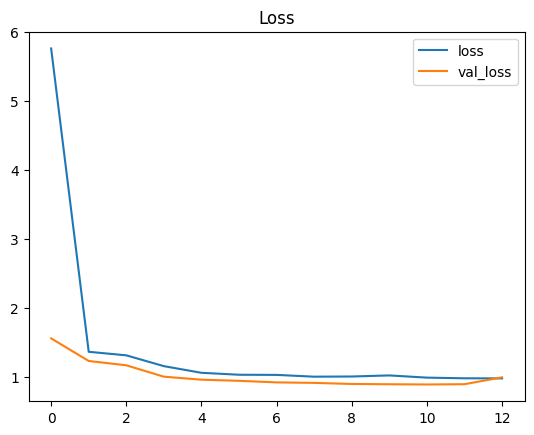

In [13]:
pd.DataFrame(history.history).plot()
plt.title("Loss")
plt.show()

In [14]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
print('### Result on the Training Set ###')
compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test)

### Result on the Training Set ###
URDU (SOURCE)                  ROMAN (TARGET)            AUTOMATIC TRANSLATION IN ROMAN

امریکہ میں مسلمان نماز پڑھنے کی پاداش میں ملازمت سے فارغ america mein musalman namaz parhnay ki padaash mein mulazmat se se ki ke ke ke
آپ بھی تو ساتھ ہیں نا میرے     aap bhi to sath hain na ne ki ke ke
خرم شہزاد خرم جنوری            khurram shahzad khurram january ki
دوست ہوتا تو کیا یہ ممکن تھا   dost hota to kya ki mumkin tha ki ke ke
دسمبر رخصت کردیتے ہیں          decemeber rukhsat kardete hain 
ننھی پری کی نقالی کی کوشش کی ہے nanhi pari ki naqali ki koshish ki hai ki ke ke
افغانستان کو ابھی غیر ملکی امداد پر انحصار کرنا پڑتا ہے اور میں زر مبادلہ کے بیرونی ذخائر صرف پچاس کروڑ امریکی ڈالر کے لگ بھگ تھے afghanistan ko abhi ghair mulki imdaad par inhisaar karna parta hai aur mein zar mubadla ke bairooni zakhair sirf pachaas crore amrici dollar ke lag bhag they ki ke ke ke ke ke ke ke ke ke ke
پڑھنے کی ضرورت میں             parhnay ki zaroorat mein  ki
عمران حسینی